<a href="https://colab.research.google.com/github/Memento2121/Dataflowr_Practicals/blob/main/prac_08_collaborative_filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Dataflowr](https://raw.githubusercontent.com/dataflowr/website/master/_assets/dataflowr_logo.png)](https://dataflowr.github.io/website/)

# Collaborative filtering
-----

In this example, we'll build a quick explicit feedback recommender system: that is, a model that takes into account explicit feedback signals (like ratings) to recommend new content.

We'll use an approach first made popular by the [Netflix prize](https://en.wikipedia.org/wiki/Netflix_Prize) contest: [matrix factorization](https://datajobs.com/data-science-repo/Recommender-Systems-[Netflix].pdf).

The basic idea is very simple:

1. Start with user-item-rating triplets, conveying the information that user _i_ gave some item _j_ rating _r_.
2. Represent both users and items as high-dimensional vectors of numbers. For example, a user could be represented by `[0.3, -1.2, 0.5]` and an item by `[1.0, -0.3, -0.6]`.
3. The representations should be chosen so that, when we multiplied together (via [dot products](https://en.wikipedia.org/wiki/Dot_product)), we can recover the original ratings.
4. The utility of the model then is derived from the fact that if we multiply the user vector of a user with the item vector of some item they _have not_ rated, we hope to obtain a prediction for the rating they would have given to it had they seen it.

![collaborative filtering](https://github.com/dataflowr/notebooks/blob/master/Module8/matrix_factorization.png?raw=1)


## 1. Preparations

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os.path as op

from zipfile import ZipFile
try:
    from urllib.request import urlretrieve
except ImportError:  # Python 2 compat
    from urllib import urlretrieve

# this line needs to be modified if not on colab:
data_folder = '/content/'

ML_100K_URL = "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
ML_100K_FILENAME = op.join(data_folder,ML_100K_URL.rsplit('/', 1)[1])
ML_100K_FOLDER = op.join(data_folder,'ml-100k')

We start with importing a famous dataset, the [Movielens 100k dataset](https://grouplens.org/datasets/movielens/100k/). It contains 100,000 ratings (between 1 and 5) given to 1682 movies by 943 users:

In [2]:
if not op.exists(ML_100K_FILENAME):
    print('Downloading %s to %s...' % (ML_100K_URL, ML_100K_FILENAME))
    urlretrieve(ML_100K_URL, ML_100K_FILENAME)

if not op.exists(ML_100K_FOLDER):
    print('Extracting %s to %s...' % (ML_100K_FILENAME, ML_100K_FOLDER))
    ZipFile(ML_100K_FILENAME).extractall(data_folder)

Extracting /content/ml-100k.zip to /content/ml-100k...


Other datasets, see: [Movielens](https://grouplens.org/datasets/movielens/)

## 2. Data analysis and formating

[Python Data Analysis Library](http://pandas.pydata.org/)

In [3]:
import pandas as pd

all_ratings = pd.read_csv(op.join(ML_100K_FOLDER, 'u.data'), sep='\t',
                          names=["user_id", "item_id", "ratings", "timestamp"])
all_ratings.head()

,user_id,item_id,ratings,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


Let's check out a few macro-stats of our dataset

In [4]:
list_movies_names = []
list_item_ids = []
with open(op.join(ML_100K_FOLDER, 'u.item'), encoding = "ISO-8859-1") as fp:
    for line in fp:
        list_item_ids.append(line.split('|')[0])
        list_movies_names.append(line.split('|')[1])

movies_names = pd.DataFrame(list(zip(list_item_ids, list_movies_names)),
               columns =['item_id', 'item_name'])
movies_names.head()

,item_id,item_name
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [5]:
movies_names['item_id']=movies_names['item_id'].astype(int)
all_ratings['item_id']=all_ratings['item_id'].astype(int)

In [6]:
all_ratings = all_ratings.merge(movies_names,on='item_id')
all_ratings.head()

,user_id,item_id,ratings,timestamp,item_name
0,196,242,3,881250949,Kolya (1996)
1,186,302,3,891717742,L.A. Confidential (1997)
2,22,377,1,878887116,Heavyweights (1994)
3,244,51,2,880606923,Legends of the Fall (1994)
4,166,346,1,886397596,Jackie Brown (1997)


In [7]:
#number of entries
len(all_ratings)

100000

In [8]:
all_ratings['ratings'].describe()

,ratings
count,100000.000000
mean,3.529860
std,1.125674
min,1.000000
25%,3.000000
50%,4.000000
75%,4.000000
max,5.000000


In [9]:
# number of unique rating values
len(all_ratings['ratings'].unique())

5

In [10]:
all_ratings['user_id'].describe()

,user_id
count,100000.00000
mean,462.48475
std,266.61442
min,1.00000
25%,254.00000
50%,447.00000
75%,682.00000
max,943.00000


In [11]:
# number of unique users
total_user_id = len(all_ratings['user_id'].unique())
print(total_user_id)

943


In [12]:
all_ratings['item_id'].describe()

,item_id
count,100000.000000
mean,425.530130
std,330.798356
min,1.000000
25%,175.000000
50%,322.000000
75%,631.000000
max,1682.000000


In [13]:
# number of unique rated items
total_item_id = len(all_ratings['item_id'].unique())
print(total_item_id)

1682


In [14]:
all_ratings['item_id'] = all_ratings['item_id'].apply(lambda x :x-1)
all_ratings['user_id'] = all_ratings['user_id'].apply(lambda x :x-1)

In [15]:
movies_names['item_id']=movies_names['item_id'].apply(lambda x: x-1)

In [16]:
movies_names=movies_names.set_index('item_id')

In [17]:
movies_names.head()

,item_name
item_id,
0,Toy Story (1995)
1,GoldenEye (1995)
2,Four Rooms (1995)
3,Get Shorty (1995)
4,Copycat (1995)


For spliting the data into _train_ and _test_ we'll be using a pre-defined function from [scikit-learn](http://scikit-learn.org/stable/)

In [18]:
from sklearn.model_selection import train_test_split

ratings_train, ratings_test = train_test_split(
    all_ratings, test_size=0.2, random_state=42)

user_id_train = ratings_train['user_id']
item_id_train = ratings_train['item_id']
rating_train = ratings_train['ratings']

user_id_test = ratings_test['user_id']
item_id_test = ratings_test['item_id']
rating_test = ratings_test['ratings']

In [19]:
len(user_id_train)

80000

In [20]:
len(user_id_train.unique())

943

In [21]:
len(item_id_train.unique())

1653

We see that all the movies are not rated in the train set.

In [22]:
movies_not_train = (set(all_ratings['item_id']) -set(item_id_train))
for m in movies_not_train:
    print(m,movies_names.loc[m]['item_name'])

1668 MURDER and murder (1996)
1545 Shadows (Cienie) (1988)
1673 Mamma Roma (1962)
1674 Sunchaser, The (1996)
1676 Sweet Nothing (1995)
1550 Glass Shield, The (1994)
1681 Scream of Stone (Schrei aus Stein) (1991)
1432 Men of Means (1998)
1564 Daens (1992)
1319 Homage (1995)
813 Great Day in Harlem, A (1994)
1459 Sleepover (1995)
1595 Nemesis 2: Nebula (1995)
1598 Someone Else's America (1995)
1600 Office Killer (1997)
1602 Angela (1995)
1348 Mille bolle blu (1993)
1351 Shadow of Angels (Schatten der Engel) (1976)
1363 Bird of Prey (1996)
1492 Modern Affair, A (1995)
1631 Land and Freedom (Tierra y libertad) (1995)
1121 They Made Me a Criminal (1939)
1636 Girls Town (1996)
1639 Eighth Day, The (1996)
1640 Dadetown (1995)
1647 Niagara, Niagara (1997)
1648 Big One, The (1997)
1654 Favor, The (1994)
1535 Aiqing wansui (1994)


In [23]:
user_id_train.iloc[:5]

,user_id
75220,806
48955,473
44966,462
13568,138
92727,620


In [24]:
item_id_train.iloc[:5]

,item_id
75220,1410
48955,658
44966,267
13568,285
92727,750


In [25]:
rating_train.iloc[:5]

,ratings
75220,1
48955,5
44966,4
13568,4
92727,4


## 3. The model

We can feed our dataset to the `FactorizationModel` class - a sklearn-like object that allows us to train and evaluate the explicit factorization models.

Internally, the model uses the `Model_dot`(class to represents users and items. It's composed of a 4 `embedding` layers:

- a `(num_users x latent_dim)` embedding layer to represent users,
- a `(num_items x latent_dim)` embedding layer to represent items,
- a `(num_users x 1)` embedding layer to represent user biases, and
- a `(num_items x 1)` embedding layer to represent item biases.

In [26]:
import torch.nn as nn
import torch

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Let's generate [Embeddings](http://pytorch.org/docs/master/nn.html#embedding) for the users, _i.e._ a fixed-sized vector describing the user

In [28]:
embedding_dim = 3
embedding_user = nn.Embedding(total_user_id, embedding_dim)
input = torch.LongTensor([[1,2,4,5],[4,3,2,0]])
embedding_user(input)

tensor([[[-1.9482,  0.0723, -2.0915],
         [ 0.8824, -1.0185, -1.3356],
         [-0.2564, -0.6312, -0.1638],
         [ 0.6186, -0.8018,  0.9368]],

        [[-0.2564, -0.6312, -0.1638],
         [ 0.2486,  0.2240,  2.2857],
         [ 0.8824, -1.0185, -1.3356],
         [ 1.1359,  0.8600,  1.7119]]], grad_fn=<EmbeddingBackward0>)

We will use some custom embeddings and dataloader

In [29]:
class ScaledEmbedding(nn.Embedding):
    """
    Embedding layer that initialises its values
    to using a normal variable scaled by the inverse
    of the embedding dimension.
    """
    def reset_parameters(self):
        """
        Initialize parameters.
        """
        self.weight.data.normal_(0, 1.0 / self.embedding_dim)
        if self.padding_idx is not None:
            self.weight.data[self.padding_idx].fill_(0)


class ZeroEmbedding(nn.Embedding):
    """
    Used for biases.
    """
    def reset_parameters(self):
        """
        Initialize parameters.
        """
        self.weight.data.zero_()
        if self.padding_idx is not None:
            self.weight.data[self.padding_idx].fill_(0)

In [30]:
class DotModel(nn.Module):

    def __init__(self,
                 num_users,
                 num_items,
                 embedding_dim=32):

        super(DotModel, self).__init__()

        self.embedding_dim = embedding_dim

        self.user_embeddings = ScaledEmbedding(num_users, embedding_dim)
        self.item_embeddings = ScaledEmbedding(num_items, embedding_dim)
        self.user_biases = ZeroEmbedding(num_users, 1)
        self.item_biases = ZeroEmbedding(num_items, 1)


    def forward(self, user_ids, item_ids): # ([context_size])

        user_embd = self.user_embeddings(user_ids) # ([context_size, embedding_dim])
        item_embd = self.item_embeddings(item_ids) # "..."
        user_bias = self.user_biases(user_ids) # ([context_size, 1])
        item_bias = self.item_biases(item_ids) # "..."
        user_embd += user_bias
        item_embd += item_bias

        return (user_embd * item_embd).sum(dim = 1) # ([context_size])


In [31]:
net = DotModel(total_user_id,total_item_id).to(device)

Now test your network on a small batch.

In [32]:
batch_users_np = user_id_train.values[:5].astype(np.int32)
batch_items_np = item_id_train.values[:5].astype(np.int32)
batch_ratings_np = rating_train[:5].values.astype(np.float32)
batch_users_tensor = torch.LongTensor(batch_users_np).to(device)
batch_items_tensor = torch.LongTensor(batch_items_np).to(device)
batch_ratings_tensor = torch.tensor(batch_ratings_np).to(device)

In [33]:
predictions = net(batch_users_tensor,batch_items_tensor)

In [34]:
predictions

tensor([0.0042, 0.0050, 0.0013, 0.0004, 0.0035], grad_fn=<SumBackward1>)

We will use MSE loss defined below:

In [35]:
def regression_loss(predicted_ratings, observed_ratings):
    return ((observed_ratings - predicted_ratings) ** 2).mean()

In [36]:
loss_fn = regression_loss
loss = loss_fn(predictions, batch_ratings_tensor)

In [37]:
loss

tensor(14.7799, grad_fn=<MeanBackward0>)

Check that your network is learning by overfitting your network on this small batch (you should reach a loss below 0.5 in the cell below).

In [38]:
net = DotModel(total_user_id,total_item_id).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr = 0.1)
for e in range(15):
    preds = net(batch_users_tensor, batch_items_tensor)
    loss = loss_fn(preds, batch_ratings_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(loss.item())
    #
    # your code here
    #

14.815004348754883
12.752120971679688
6.356452465057373
4.697931289672852
4.141570091247559
0.8368818163871765
0.4556766450405121
1.9241702556610107
2.805940628051758
2.0003914833068848
0.6662784814834595
0.20054566860198975
0.7974745035171509
1.2708919048309326
1.042012333869934


In [39]:
def shuffle(*arrays):

    random_state = np.random.RandomState()
    shuffle_indices = np.arange(len(arrays[0]))
    random_state.shuffle(shuffle_indices)

    if len(arrays) == 1:
        return arrays[0][shuffle_indices]
    else:
        return tuple(x[shuffle_indices] for x in arrays)

In [40]:
def minibatch(batch_size, *tensors):

    if len(tensors) == 1:
        tensor = tensors[0]
        for i in range(0, len(tensor), batch_size):
            yield tensor[i:i + batch_size]
    else:
        for i in range(0, len(tensors[0]), batch_size):
            yield tuple(x[i:i + batch_size] for x in tensors)



In [50]:
import imp
import numpy as np

import torch.optim as optim

class FactorizationModel(object):

    def __init__(self, embedding_dim=32, n_iter=10, batch_size=256, l2=0.0,
                 learning_rate=1e-2, device=device, net=None, num_users=None,
                 num_items=None,random_state=None):

        self._embedding_dim = embedding_dim
        self._n_iter = n_iter
        self._learning_rate = learning_rate
        self._batch_size = batch_size
        self._l2 = l2
        self._device = device
        self._num_users = num_users
        self._num_items = num_items
        self._net = net
        self._optimizer = None
        self._loss_func = None
        self._random_state = random_state or np.random.RandomState()


    def _initialize(self):
        if self._net is None:
            self._net = DotModel(self._num_users, self._num_items, self._embedding_dim).to(self._device)

        self._optimizer = optim.Adam(
                self._net.parameters(),
                lr=self._learning_rate,
                weight_decay=self._l2
            )

        self._loss_func = regression_loss

    @property
    def _initialized(self):
        return self._optimizer is not None


    def fit(self, user_ids, item_ids, ratings, verbose=True):

        user_ids = user_ids.astype(np.int64)
        item_ids = item_ids.astype(np.int64)

        if not self._initialized:
            self._initialize()

        for epoch_num in range(self._n_iter):
            users, items, ratingss = shuffle(user_ids,
                                            item_ids,
                                            ratings)

            user_ids_tensor = torch.from_numpy(users).to(self._device)
            item_ids_tensor = torch.from_numpy(items).to(self._device)
            ratings_tensor = torch.from_numpy(ratingss).to(self._device)
            epoch_loss = 0.0

            for (minibatch_num,
                 (batch_user,
                  batch_item,
                  batch_rating)) in enumerate(minibatch(self._batch_size,
                                                         user_ids_tensor,
                                                         item_ids_tensor,
                                                         ratings_tensor)):


                # beging to be completed
                predictions = self._net(batch_user, batch_item)
                loss = self._loss_func(predictions, batch_rating)
                epoch_loss += loss.item()
                self._optimizer.zero_grad()
                loss.backward()
                self._optimizer.step()

            epoch_loss = epoch_loss / (minibatch_num + 1)

            if verbose:
                print('Epoch {}: loss_train {}'.format(epoch_num, epoch_loss))

            if np.isnan(epoch_loss) or epoch_loss == 0.0:
                raise ValueError('Degenerate epoch loss: {}'
                                 .format(epoch_loss))


    def test(self,user_ids, item_ids, ratings):
        self._net.train(False)
        user_ids = user_ids.astype(np.int64)
        item_ids = item_ids.astype(np.int64)

        user_ids_tensor = torch.from_numpy(user_ids).to(self._device)
        item_ids_tensor = torch.from_numpy(item_ids).to(self._device)
        ratings_tensor = torch.from_numpy(ratings).to(self._device)

        predictions = self._net(user_ids_tensor, item_ids_tensor)

        loss = self._loss_func(ratings_tensor, predictions)
        return loss.data.item()

    def predict(self,user_ids, item_ids):
        self._net.train(False)
        user_ids = user_ids.astype(np.int64)
        item_ids = item_ids.astype(np.int64)

        user_ids_tensor = torch.from_numpy(user_ids).to(self._device)
        item_ids_tensor = torch.from_numpy(item_ids).to(self._device)

        predictions = self._net(user_ids_tensor, item_ids_tensor)
        return predictions.data

In [51]:
model = FactorizationModel(embedding_dim=50,  # latent dimensionality
                                   n_iter=5,  # number of epochs of training
                                   batch_size=1024,  # minibatch size
                                   learning_rate=1e-3,
                                   l2=1e-9,  # strength of L2 regularization
                                   num_users=total_user_id,
                                   num_items=total_item_id)

In [52]:
user_ids_train_np = user_id_train.values.astype(np.int32)
item_ids_train_np = item_id_train.values.astype(np.int32)
ratings_train_np = rating_train.values.astype(np.float32)
user_ids_test_np = user_id_test.values.astype(np.int64)
item_ids_test_np = item_id_test.values.astype(np.int64)
ratings_test_np = rating_test.values.astype(np.float32)

In [53]:
model.fit(user_ids_train_np, item_ids_train_np, ratings_train_np)

Epoch 0: loss_train 13.189350116102002
Epoch 1: loss_train 5.235462519186962
Epoch 2: loss_train 1.295650471614886
Epoch 3: loss_train 0.9864987270741523
Epoch 4: loss_train 0.9148518744903275


In [54]:
model.test(user_ids_test_np, item_ids_test_np, ratings_test_np  )

0.9378318190574646

In [55]:
print(model._net)

DotModel(
  (user_embeddings): ScaledEmbedding(943, 50)
  (item_embeddings): ScaledEmbedding(1682, 50)
  (user_biases): ZeroEmbedding(943, 1)
  (item_biases): ZeroEmbedding(1682, 1)
)


In [56]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

test_preds = model.predict(user_ids_test_np, item_ids_test_np)
print("Final test RMSE: %0.3f" % np.sqrt(mean_squared_error(test_preds.cpu(), ratings_test_np)))
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds.cpu(), ratings_test_np))

Final test RMSE: 0.968
Final test MAE: 0.759


You can compare with [Surprise](https://github.com/NicolasHug/Surprise)

## 4. Best and worst movies

Getting the name of the movies (there must be a better way, please provide alternate solutions!)

In [57]:
list_movies_names = []
list_item_ids = []
with open(op.join(ML_100K_FOLDER, 'u.item'), encoding = "ISO-8859-1") as fp:
    for line in fp:
        list_item_ids.append(line.split('|')[0])
        list_movies_names.append(line.split('|')[1])

movies_names = pd.DataFrame(list(zip(list_item_ids, list_movies_names)),
               columns =['item_id', 'item_name'])
movies_names.head()

,item_id,item_name
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [58]:
item_bias_np = model._net.item_biases.weight.data.cpu().numpy()

In [59]:
movies_names['biases'] = pd.Series(item_bias_np.T[0], index=movies_names.index)

In [60]:
movies_names.head()

,item_id,item_name,biases
0,1,Toy Story (1995),0.153295
1,2,GoldenEye (1995),0.128638
2,3,Four Rooms (1995),0.125834
3,4,Get Shorty (1995),0.143742
4,5,Copycat (1995),0.127068


In [61]:
movies_names.shape

(1682, 3)

In [62]:
indices_item_train = np.sort(item_id_train.unique())
movies_names = movies_names.loc[indices_item_train]
movies_names.shape

(1653, 3)

In [63]:
movies_names = movies_names.sort_values(ascending=False,by=['biases'])

Best movies

In [64]:
movies_names.head(10)

,item_id,item_name,biases
271,272,Good Will Hunting (1997),0.180417
168,169,"Wrong Trousers, The (1993)",0.179582
407,408,"Close Shave, A (1995)",0.176307
317,318,Schindler's List (1993),0.175619
11,12,"Usual Suspects, The (1995)",0.174919
177,178,12 Angry Men (1957),0.172947
284,285,Secrets & Lies (1996),0.172695
656,657,"Manchurian Candidate, The (1962)",0.172369
49,50,Star Wars (1977),0.172337
315,316,As Good As It Gets (1997),0.171431


Worse movies

In [65]:
movies_names.tail(10)

,item_id,item_name,biases
1568,1569,"Vie est belle, La (Life is Rosey) (1987)",0.027184
1565,1566,"Man from Down Under, The (1943)",0.027038
1560,1561,Tigrero: A Film That Was Never Made (1994),0.026729
1338,1339,Stefano Quantestorie (1993),0.026330
1357,1358,The Deadly Cure (1996),0.026147
1340,1341,Hedd Wyn (1992),0.025851
851,852,"Bloody Child, The (1996)",0.025414
1365,1366,JLG/JLG - autoportrait de décembre (1994),0.024621
1328,1329,"Low Life, The (1994)",0.024423
1347,1348,Every Other Weekend (1990),0.023579


## 5. PCA

In [66]:
item_emb_np = model._net.item_embeddings.weight.data.cpu().numpy()
item_emb_np.shape

(1682, 50)

In [67]:
from sklearn.decomposition import PCA
from operator import itemgetter

pca = PCA(n_components=3)
latent_fac = pca.fit_transform(item_emb_np)

In [68]:
movie_comp = [(f, i) for f,i in zip(latent_fac[:,1], list_movies_names)]

In [69]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.0735929, 'Gaslight (1944)'),
 (0.07337689, 'Cérémonie, La (1995)'),
 (0.07147471, 'Dead Man (1995)'),
 (0.07101508, 'Contempt (Mépris, Le) (1963)'),
 (0.068334155, 'I Love Trouble (1994)'),
 (0.06693649, 'Faces (1968)'),
 (0.065216415, 'Stonewall (1995)'),
 (0.064550474, 'A Chef in Love (1996)'),
 (0.064545706, 'Breaking the Waves (1996)'),
 (0.064039305, 'Germinal (1993)')]

In [70]:
sorted(movie_comp, key=itemgetter(0), reverse=False)[:10]

[(-0.09656511, 'Feeling Minnesota (1996)'),
 (-0.08501299, 'Seven Years in Tibet (1997)'),
 (-0.08428442, 'Manhattan Murder Mystery (1993)'),
 (-0.08118319, 'Conspiracy Theory (1997)'),
 (-0.07166605, 'Leave It to Beaver (1997)'),
 (-0.06938485, 'Bottle Rocket (1996)'),
 (-0.06839066, 'Rocket Man (1997)'),
 (-0.06789354, 'Titanic (1997)'),
 (-0.06788726, 'Gang Related (1997)'),
 (-0.067136504, 'Father of the Bride Part II (1995)')]

In [71]:
g = all_ratings.groupby('item_name')['ratings'].count()
most_rated_movies = g.sort_values(ascending=False).index.values[:1000]
most_rated_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)',
       'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)',
       'Air Force One (1997)', 'Independence Day (ID4) (1996)'],
      dtype=object)

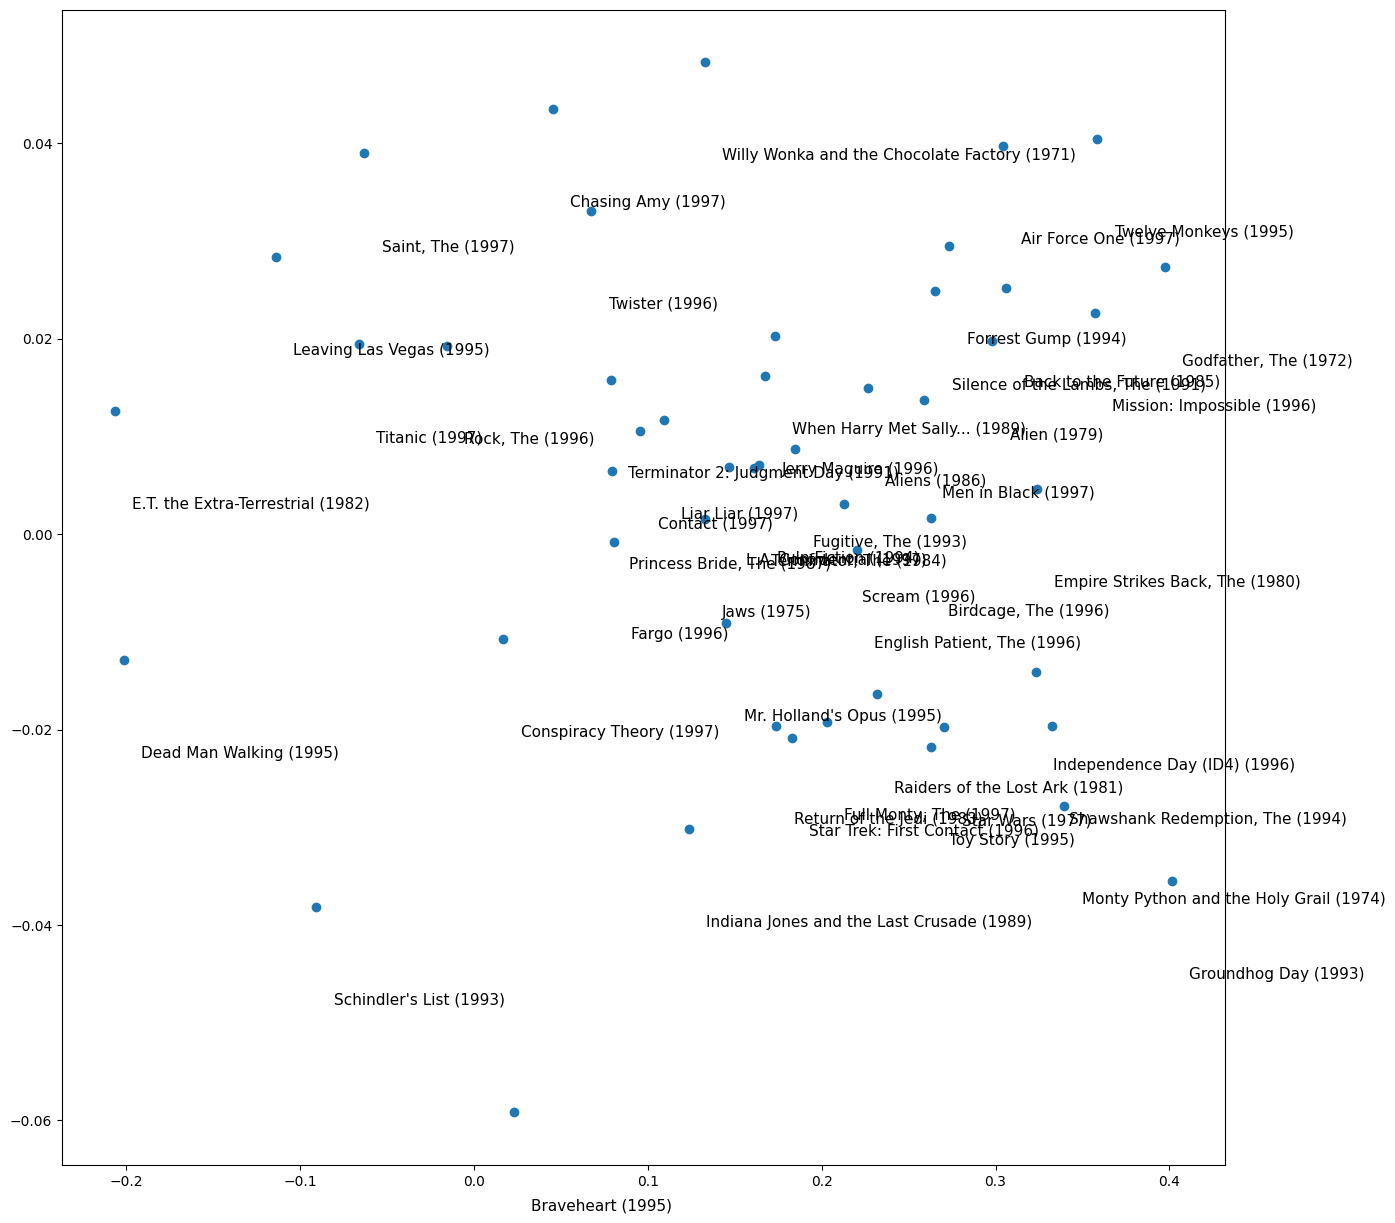

In [72]:
idxs = range(50)
txt_movies_names = most_rated_movies[:len(idxs)]
X = latent_fac[idxs,0]
Y = latent_fac[idxs,2]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(txt_movies_names, X, Y):
    plt.text(x+0.01,y-0.01,i, fontsize=11)
plt.show()

## 6. SPOTLIGHT

The code written above is a simplified version of [SPOTLIGHT](https://github.com/maciejkula/spotlight)

Once you installed it with: `conda install -c maciejkula -c pytorch spotlight=0.1.5`, you can compare the results...

In [74]:
![Dataflowr](https://raw.githubusercontent.com/dataflowr/website/master/_assets/dataflowr_logo.png)(https://dataflowr.github.io/website/)

/bin/bash: -c: line 1: syntax error near unexpected token `https://raw.githubusercontent.com/dataflowr/website/master/_assets/dataflowr_logo.png'
/bin/bash: -c: line 1: `[Dataflowr](https://raw.githubusercontent.com/dataflowr/website/master/_assets/dataflowr_logo.png)(https://dataflowr.github.io/website/)'
